# I. Definition

## Project Overiview

The Programme for International Student Assessment (PISA) is a worldwide study of 15-year-old school pupils' scholastic performance on mathematics, science, and reading.

In this project, we will predict the reading scores of students using the background information such as parents education, school size, using computer for homework, etc., provided by student and the School. We use PISA 2009 dataset as reading literacy was the main domain assessed in 2009.


## Problem Statement

The goal is to train a model to predict the reading score of student using their demographical information. Since this is a problem of supervised learning of type regression. Several regression algorithms will be explored, as discussed in Phase II, Analysis.

## Metrics

We will use two metrics:
* RMSE(Root Mean Squared Error)
* R^2(R-squared)

# II. Analysis

In [1]:
# import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import timeit

# Use average of scores as benchmark
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import model_selection


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


## Data Exploration

### Load the dataset

In [2]:
pisa = pd.read_csv('pisa2009.csv')
print('Shape of dataset: ',pisa.shape)

('Shape of dataset: ', (5233, 24))


## Exploratory Visualization

In [3]:
pisa.dtypes

grade                      int64
male                       int64
raceeth                   object
preschool                float64
expectBachelors          float64
motherHS                 float64
motherBachelors          float64
motherWork               float64
fatherHS                 float64
fatherBachelors          float64
fatherWork               float64
selfBornUS               float64
motherBornUS             float64
fatherBornUS             float64
englishAtHome            float64
computerForSchoolwork    float64
read30MinsADay           float64
minutesPerWeekEnglish    float64
studentsInEnglish        float64
schoolHasLibrary         float64
publicSchool               int64
urban                      int64
schoolSize               float64
readingScore             float64
dtype: object

In [4]:
pisa.head()

,grade,male,raceeth,preschool,expectBachelors,motherHS,motherBachelors,motherWork,fatherHS,fatherBachelors,...,englishAtHome,computerForSchoolwork,read30MinsADay,minutesPerWeekEnglish,studentsInEnglish,schoolHasLibrary,publicSchool,urban,schoolSize,readingScore
0,11,1,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,...,0.0,1.0,0.0,225.0,NaN,1.0,1,1,673.0,476.00
1,11,1,White,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,450.0,25.0,1.0,1,0,1173.0,575.01
2,9,1,White,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,0.0,250.0,28.0,1.0,1,0,1233.0,554.81
3,10,0,Black,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,200.0,23.0,1.0,1,1,2640.0,458.11
4,10,1,Hispanic,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,250.0,35.0,1.0,1,1,1095.0,613.89


### Missing Values

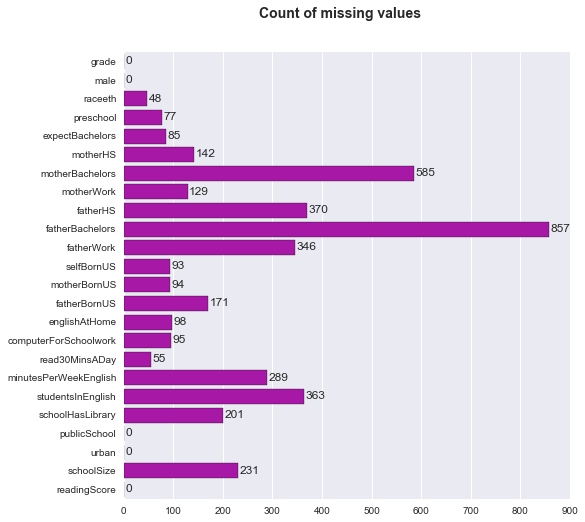

In [5]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Count of missing values', fontsize=14, fontweight='bold')
null_data = pisa.isnull().sum()
ax = sns.barplot(x = null_data.values, y=null_data.index, color="m" )
i = 0
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3, p.get_y() + 0.5, null_data.values[i])
    i += 1

In [7]:
# Continuous Features
contFeatures = ['minutesPerWeekEnglish','studentsInEnglish','schoolSize']
pisa[contFeatures].describe()

,minutesPerWeekEnglish,studentsInEnglish,schoolSize
count,4944.000000,4870.000000,5002.000000
mean,265.717840,24.559754,1374.367653
std,149.591118,7.139661,870.424790
min,0.000000,1.000000,100.000000
25%,225.000000,20.000000,712.000000
50%,250.000000,25.000000,1233.000000
75%,300.000000,30.000000,1900.000000
max,2400.000000,90.000000,6694.000000


### Bivariate plots on continuous predictors

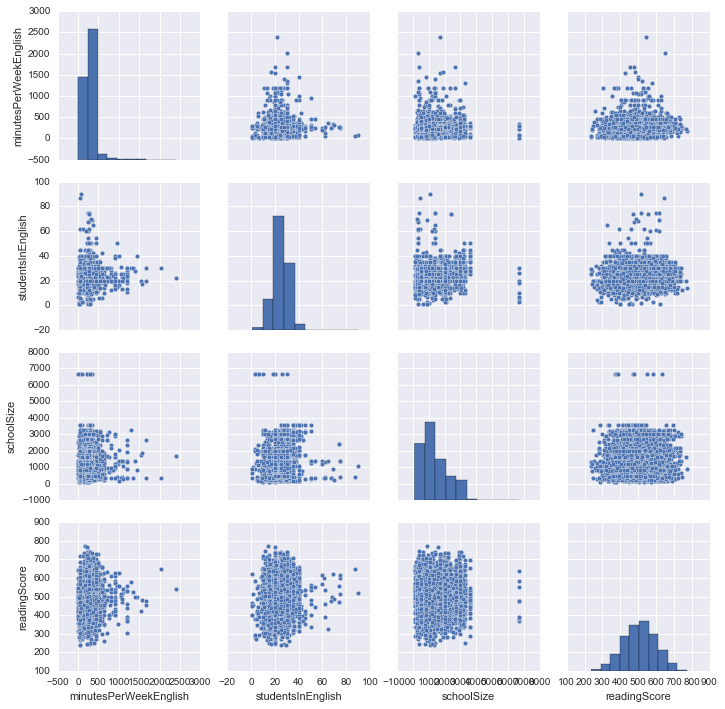

In [8]:
_ = sns.pairplot(pisa[contFeatures + ['readingScore']].dropna())

### Outliers

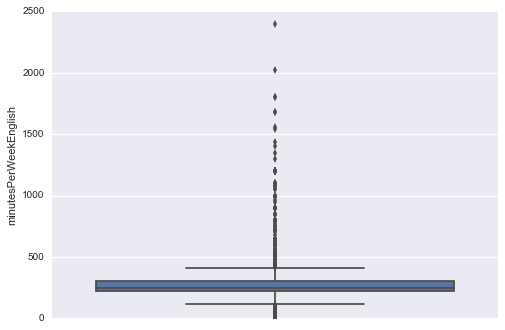

In [17]:
sns.boxplot(y=pisa["minutesPerWeekEnglish"])

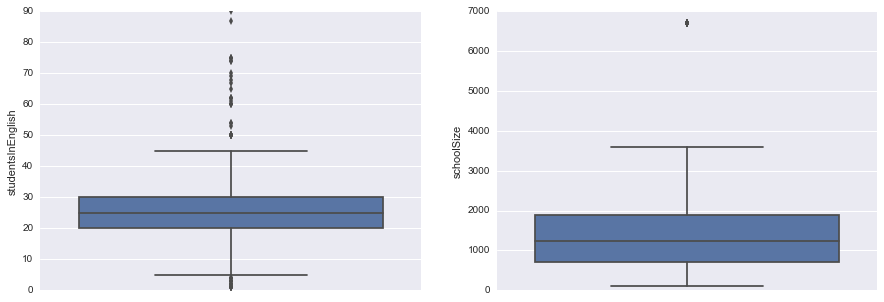

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.boxplot(y= pisa["studentsInEnglish"], ax=ax[0])
sns.boxplot(y= pisa["schoolSize"], ax=ax[1])

### Correlation

In [23]:
from IPython.display import display
tempdf = pisa.copy()

raceeth = pd.get_dummies(tempdf['raceeth'], 'r')
tempdf = pd.concat([tempdf, raceeth], axis=1)
tempdf = tempdf.drop('raceeth', axis=1)

#move the prediction target towards the end
tempdf = tempdf.drop('readingScore', axis=1)
tempdf['readingScore'] = pisa['readingScore']

raceeth
corr = tempdf.corr(method='pearson')
with pd.option_context('display.max_columns', None):
    display(corr)

,grade,male,preschool,expectBachelors,motherHS,motherBachelors,motherWork,fatherHS,fatherBachelors,fatherWork,selfBornUS,motherBornUS,fatherBornUS,englishAtHome,computerForSchoolwork,read30MinsADay,minutesPerWeekEnglish,studentsInEnglish,schoolHasLibrary,publicSchool,urban,schoolSize,r_American Indian/Alaska Native,r_Asian,r_Black,r_Hispanic,r_More than one race,r_Native Hawaiian/Other Pacific Islander,r_White,readingScore
grade,1.000000,-0.089213,-0.011200,0.148041,0.028976,0.043972,0.042522,0.068751,0.056805,0.010012,-0.015076,-0.062865,-0.057618,-0.009583,0.105568,0.065484,0.045747,0.074487,-0.016703,-0.059306,0.080561,0.063289,-0.023408,0.084707,-0.033769,-0.013163,-0.005996,0.029203,0.004317,0.272413
male,-0.089213,1.000000,0.005507,-0.088671,0.031166,0.048206,-0.016717,0.016752,0.057838,0.030472,0.013215,0.002977,0.012652,-0.005748,-0.028993,-0.214101,0.009808,-0.036348,0.022453,-0.075265,0.016113,-0.004586,0.022623,-0.023206,-0.010602,0.015579,-0.008216,0.019584,-0.000760,-0.145303
preschool,-0.011200,0.005507,1.000000,0.095978,0.140893,0.154680,0.069062,0.137600,0.146597,0.054756,0.093149,0.110534,0.113289,0.122812,0.094145,-0.003884,-0.012829,-0.030150,0.029039,-0.076767,-0.056366,-0.024381,-0.002954,-0.001570,0.039726,-0.120714,0.000731,-0.001656,0.077568,0.060373
expectBachelors,0.148041,-0.088671,0.095978,1.000000,0.109735,0.174178,0.070219,0.151738,0.208115,0.023476,-0.002508,0.009766,0.009201,0.035530,0.132233,0.125497,0.008403,0.041987,0.055405,-0.113289,0.006144,0.021538,-0.032191,0.062091,-0.008816,-0.088334,-0.000554,0.003074,0.064732,0.359425
motherHS,0.028976,0.031166,0.140893,0.109735,1.000000,0.252665,0.170211,0.509090,0.229883,0.036855,0.176047,0.344936,0.337395,0.376071,0.182245,0.020236,0.031403,-0.042705,0.021296,-0.074333,-0.116650,-0.089987,-0.004978,-0.044241,0.062062,-0.348739,0.024971,0.006369,0.260682,0.161376
motherBachelors,0.043972,0.048206,0.154680,0.174178,0.252665,1.000000,0.133704,0.210307,0.539321,0.067062,0.028062,0.140357,0.119619,0.160095,0.144212,0.033012,0.017249,-0.043409,0.022864,-0.172575,-0.040708,-0.007501,-0.023187,0.010866,-0.000595,-0.206743,0.007320,-0.006831,0.173525,0.213743
motherWork,0.042522,-0.016717,0.069062,0.070219,0.170211,0.133704,1.000000,0.115492,0.046268,0.054015,0.067138,0.102452,0.094600,0.121524,0.091743,-0.027740,0.022426,-0.011111,-0.007515,-0.025414,-0.027873,-0.047528,-0.021544,-0.025607,0.041216,-0.102118,0.013330,-0.005968,0.071580,0.047248
fatherHS,0.068751,0.016752,0.137600,0.151738,0.509090,0.210307,0.115492,1.000000,0.281755,0.107036,0.150403,0.298765,0.320266,0.336876,0.170892,0.046933,0.036223,-0.020973,0.036179,-0.086946,-0.100400,-0.083902,-0.018314,0.017634,0.044931,-0.339347,0.019806,0.017167,0.241250,0.188446
fatherBachelors,0.056805,0.057838,0.146597,0.208115,0.229883,0.539321,0.046268,0.281755,1.000000,0.108559,-0.008772,0.068955,0.072586,0.125238,0.172355,0.057101,0.008416,-0.031457,0.006428,-0.188413,-0.007594,0.031286,-0.044834,0.072559,-0.062323,-0.202203,-0.012158,-0.011727,0.192768,0.260840
fatherWork,0.010012,0.030472,0.054756,0.023476,0.036855,0.067062,0.054015,0.107036,0.108559,1.000000,-0.024228,-0.004170,-0.007727,0.013639,0.083243,-0.012241,0.023599,0.003508,-0.003134,-0.020203,-0.029030,-0.022164,-0.042797,-0.010644,-0.095892,-0.020836,-0.014122,-0.033243,0.102633,0.067909


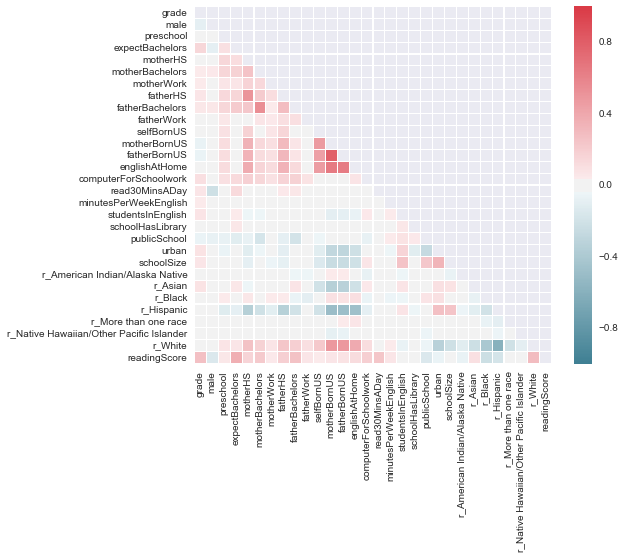

In [24]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
#
# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#
# # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmax=1,
            square=True,linewidths=.1, cbar_kws={"shrink": .8}, ax=ax)
plt.show()

In [25]:
cor_dict = corr['readingScore'].to_dict()
del cor_dict['readingScore']
print("List the numerical features decendingly by their correlation with Reading Score:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("%21s: %.3f" %(ele))

List the numerical features decendingly by their correlation with Reading Score:

      expectBachelors: 0.359
              r_White: 0.291
                grade: 0.272
      fatherBachelors: 0.261
       read30MinsADay: 0.241
              r_Black: -0.225
      motherBachelors: 0.214
computerForSchoolwork: 0.190
             fatherHS: 0.188
           r_Hispanic: -0.185
             motherHS: 0.161
                 male: -0.145
         publicSchool: -0.141
        englishAtHome: 0.121
              r_Asian: 0.096
         fatherBornUS: 0.085
r_American Indian/Alaska Native: -0.070
minutesPerWeekEnglish: 0.068
           fatherWork: 0.068
         motherBornUS: 0.066
                urban: -0.062
            preschool: 0.060
           motherWork: 0.047
           selfBornUS: 0.039
           schoolSize: 0.035
    studentsInEnglish: 0.033
     schoolHasLibrary: 0.020
r_Native Hawaiian/Other Pacific Islander: 0.014
 r_More than one race: -0.000


### Bivariate visualizations

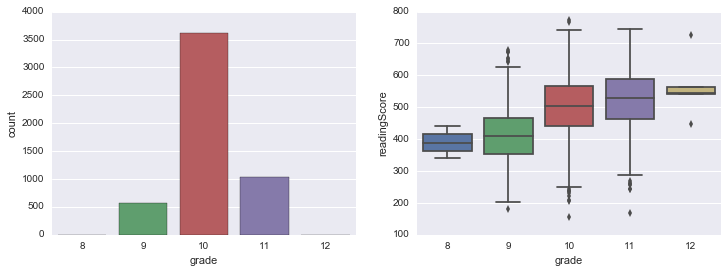

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.countplot(x='grade', data=pisa, ax=ax[0])
sns.boxplot(x='grade', y='readingScore', data=pisa, ax=ax[1])
plt.show()

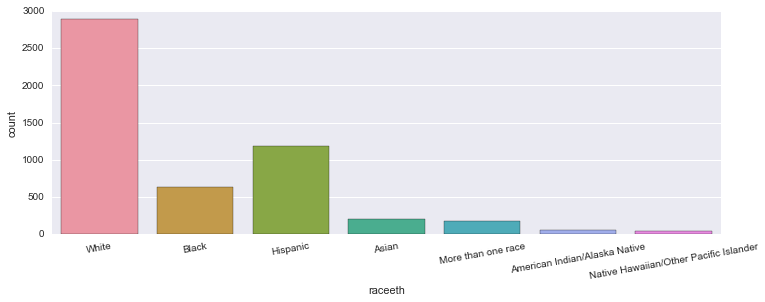

In [27]:
fig = plt.figure(figsize=(12, 4))
sns.countplot(x='raceeth', data=pisa)
a = plt.xticks(rotation = 10)

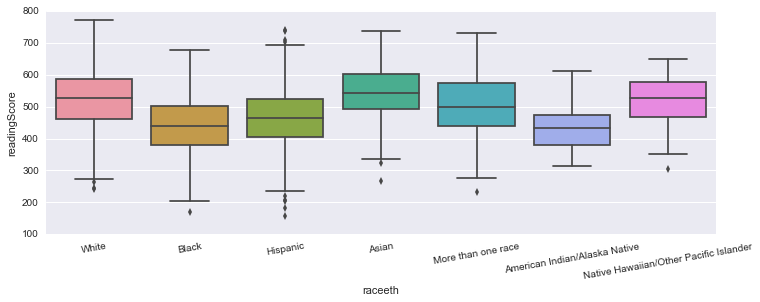

In [28]:
fig = plt.figure(figsize=(12, 4))
sns.boxplot(x='raceeth', y='readingScore', data=pisa)
x = plt.xticks(rotation = 10)
plt.show()

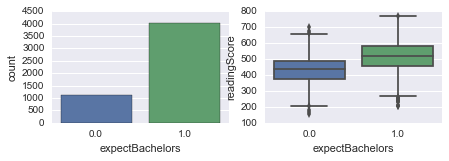

In [29]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='expectBachelors', data=pisa, ax=ax[0])
sns.boxplot(x='expectBachelors', y='readingScore', data=pisa, ax=ax[1])
plt.show()

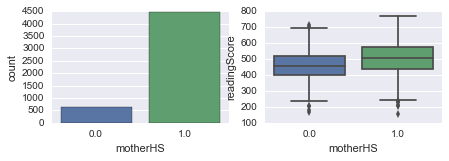

In [30]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='motherHS', data=pisa, ax=ax[0])
sns.boxplot(x='motherHS', y='readingScore', data=pisa, ax=ax[1])
plt.show()

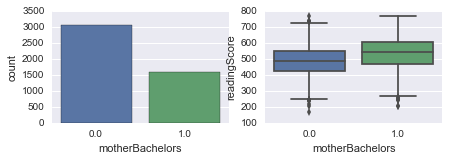

In [31]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='motherBachelors', data=pisa, ax=ax[0])
sns.boxplot(x='motherBachelors', y='readingScore', data=pisa, ax=ax[1])
plt.show()

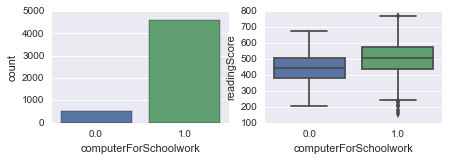

In [32]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='computerForSchoolwork', data=pisa, ax=ax[0])
sns.boxplot(x='computerForSchoolwork', y='readingScore', data=pisa, ax=ax[1])
plt.show()

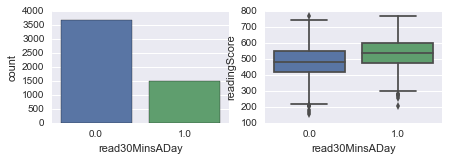

In [33]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='read30MinsADay', data=pisa, ax=ax[0])
sns.boxplot(x='read30MinsADay', y='readingScore', data=pisa, ax=ax[1])
plt.show()

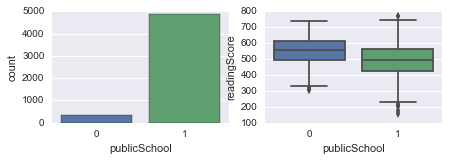

In [34]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='publicSchool', data=pisa, ax=ax[0])
sns.boxplot(x='publicSchool', y='readingScore', data=pisa, ax=ax[1])
plt.show()

## Algorithms and Techniques

## Benchmark

In [3]:
# Use average of scores as benchmark
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = LinearRegression()

withoutNa = pisa.dropna()
X = withoutNa.drop(['readingScore', 'raceeth'], axis=1)
y = withoutNa['readingScore']

kfold = KFold(n_splits=10, random_state=7)
cv_rmse = np.sqrt(-cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')

print cv_rmse.mean()
print cv_r2.mean()


print(pisa.shape)


77.3750215458
0.241581166205
(5233, 24)


# III. Methodology
## Data Preprocessing

### Handling Missing Values

In [4]:
# For continuous variables replace the missing data with average of columns
pisa['minutesPerWeekEnglish'].fillna(int(pisa['minutesPerWeekEnglish'].mean()), inplace=True)
pisa['studentsInEnglish'].fillna(int(pisa['studentsInEnglish'].mean()), inplace=True)
pisa['schoolSize'].fillna(int(pisa['schoolSize'].mean()), inplace=True)

# For 'raceeth' use 'missing' replacement
pisa['raceeth'].fillna('NoRace', inplace=True)
# For binary variable use 0 in place of missing value
pisa = pisa.apply(lambda x:x.fillna(0))


### Binning Continuous Variables

#### minutesPerWeekEnglish

In [5]:

bins = [-1, 100, 200, 300, 400, 500, 2500 ]
group_names = ['<100', '100-200', '200-300', '300-400', '400-500', '500-2500']
pisa['englishBins'] = pd.cut(pisa['minutesPerWeekEnglish'], bins, labels=group_names)
pisa = pisa.drop('minutesPerWeekEnglish', axis=1)
pisa['englishBins'].value_counts()


200-300     3337
<100         518
100-200      500
300-400      375
400-500      352
500-2500     151
Name: englishBins, dtype: int64

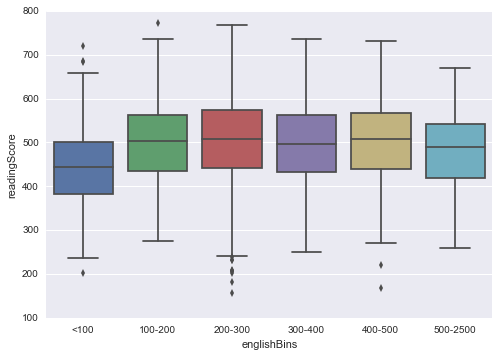

In [6]:
sns.boxplot('englishBins', 'readingScore', data=pisa)

#### studentsInEnglish

In [7]:
bins = [0, 10, 20, 30, 40, 50, 100 ]
group_names = ['<10', '10-20', '20-30', '30-40', '40-50', '50-100']
pisa['englishStudents'] = pd.cut(pisa['studentsInEnglish'], bins, labels=group_names)
pisa = pisa.drop('studentsInEnglish', axis=1)
pisa['englishStudents'].value_counts()

20-30     3105
10-20     1549
30-40      418
<10        116
40-50       23
50-100      22
Name: englishStudents, dtype: int64

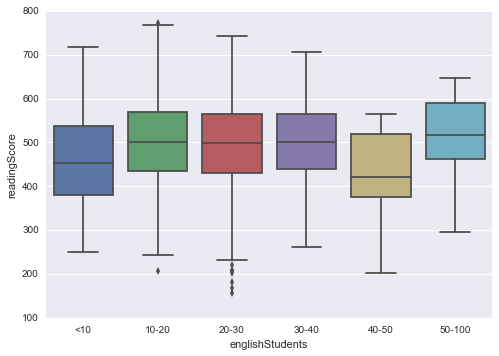

In [8]:
sns.boxplot('englishStudents', 'readingScore', data=pisa)

#### schoolSize

In [9]:
bins = [0, 100, 500, 1000, 2000, 3000, 7000 ]
group_names = ['<100', '100-500', '500-1000', '1000-2000', '2000-3000', '3000-7000']
pisa['schoolBin'] = pd.cut(pisa['schoolSize'], bins, labels=group_names)
pisa = pisa.drop('schoolSize', axis=1)
pisa['schoolBin'].value_counts()

1000-2000    2096
500-1000     1251
2000-3000     843
100-500       794
3000-7000     237
<100           12
Name: schoolBin, dtype: int64

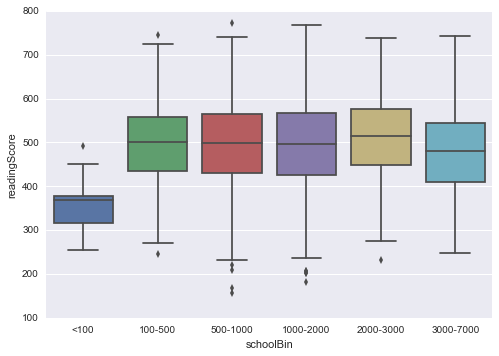

In [10]:
sns.boxplot('schoolBin', 'readingScore', data=pisa)

### Handling categorical variables

In [11]:
# Encode categorical data
raceeth = pd.get_dummies(pisa['raceeth'], 'raceeth')
pisa = pd.concat([pisa, raceeth], axis=1)
pisa = pisa.drop('raceeth', axis=1)

minutes = pd.get_dummies(pisa['englishBins'], 'minutes')
pisa = pd.concat([pisa, minutes], axis=1)
pisa = pisa.drop('englishBins', axis=1)

students = pd.get_dummies(pisa['englishStudents'], 'students')
pisa = pd.concat([pisa, students], axis=1)
pisa = pisa.drop('englishStudents', axis=1)

school = pd.get_dummies(pisa['schoolBin'], 'school')
pisa = pd.concat([pisa, school], axis=1)
pisa = pisa.drop('schoolBin', axis=1)

grade = pd.get_dummies(pisa['grade'], 'grade')
pisa = pd.concat([pisa, school], axis=1)
pisa = pisa.drop('grade', axis=1)

### Handling multicolinearity

In [12]:
# remove multicolinearity marked for removal in exploration phase
pisa = pisa.drop(['motherBachelors','motherBornUS', 'fatherBornUS'], axis=1)

In [30]:
pisa.columns.values

array(['male', 'preschool', 'expectBachelors', 'motherHS', 'motherWork',
       'fatherHS', 'fatherBachelors', 'fatherWork', 'selfBornUS',
       'englishAtHome', 'computerForSchoolwork', 'read30MinsADay',
       'schoolHasLibrary', 'publicSchool', 'urban', 'readingScore',
       'raceeth_American Indian/Alaska Native', 'raceeth_Asian',
       'raceeth_Black', 'raceeth_Hispanic', 'raceeth_More than one race',
       'raceeth_Native Hawaiian/Other Pacific Islander', 'raceeth_NoRace',
       'raceeth_White', 'minutes_<100', 'minutes_100-200',
       'minutes_200-300', 'minutes_300-400', 'minutes_400-500',
       'minutes_500-2500', 'students_<10', 'students_10-20',
       'students_20-30', 'students_30-40', 'students_40-50',
       'students_50-100', 'school_<100', 'school_100-500',
       'school_500-1000', 'school_1000-2000', 'school_2000-3000',
       'school_3000-7000', 'school_<100', 'school_100-500',
       'school_500-1000', 'school_1000-2000', 'school_2000-3000',
       'school_3

### Training Test set split

In [13]:
y = pisa['readingScore']
X = pisa.drop('readingScore', axis=1).values
#pisa = pisa.drop(['readingScore'], axis=1)
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Implementation

In [14]:
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
def spot_check_models(X, y, scoring = 'neg_mean_squared_error'):
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('LASSO', Lasso()))
    models.append(('ElasticNet', ElasticNet()))
    models.append(('Bayesian Ridge', BayesianRidge()))
    models.append(('Ridge', Ridge()))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('DecisionTree', DecisionTreeRegressor()))
    models.append(('SupprtVector', SVR()))
    models.append(('AdaBoost', AdaBoostRegressor() ))
    models.append(('GradientBoost', GradientBoostingRegressor() ))
    models.append(('RandomForests', RandomForestRegressor() ))
    models.append(('ExtraTrees', ExtraTreesRegressor()))
    
    results_rmse = []
    results_r2 = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=7)
        cv_results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring))
        cv_results_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        results_rmse.append(cv_results)
        results_r2.append(cv_results_r2)
        names.append(name)
        msg = "%7s: %.3f (%.3f) r2: %.3f (%.3f)" % \
        (name, cv_results.mean(), cv_results.std(), cv_results_r2.mean(), cv_results_r2.std())
        print(msg)
     
    # Plot RMSE comparison
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Algorithm comparison RMSE')
    ax = fig.add_subplot(111)
    sns.boxplot(y = results_rmse, x= names)
    #ax.set_xticklabels(names)
    a = plt.xticks(rotation = 20)
    plt.show()
    
    # plot R2 comparison
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Algorithm comparison R^2')
    ax = fig.add_subplot(111)
    sns.boxplot(y = results_r2, x= names)
    #ax.set_xticklabels(names)
    a = plt.xticks(rotation = 20)
    plt.show()
    

     LR: 80.675 (4.394) r2: 0.289 (0.053)
  LASSO: 79.217 (2.171) r2: 0.314 (0.023)
ElasticNet: 85.827 (2.888) r2: 0.196 (0.008)
Bayesian Ridge: 78.538 (2.070) r2: 0.326 (0.031)
  Ridge: 78.583 (2.079) r2: 0.325 (0.032)
    KNN: 86.243 (2.543) r2: 0.187 (0.036)
DecisionTree: 106.721 (3.748) r2: -0.245 (0.105)
SupprtVector: 87.503 (2.947) r2: 0.164 (0.007)
AdaBoost: 81.780 (2.480) r2: 0.274 (0.025)
GradientBoost: 78.066 (2.229) r2: 0.334 (0.034)
RandomForests: 86.438 (2.415) r2: 0.189 (0.055)
ExtraTrees: 104.857 (3.540) r2: -0.200 (0.108)


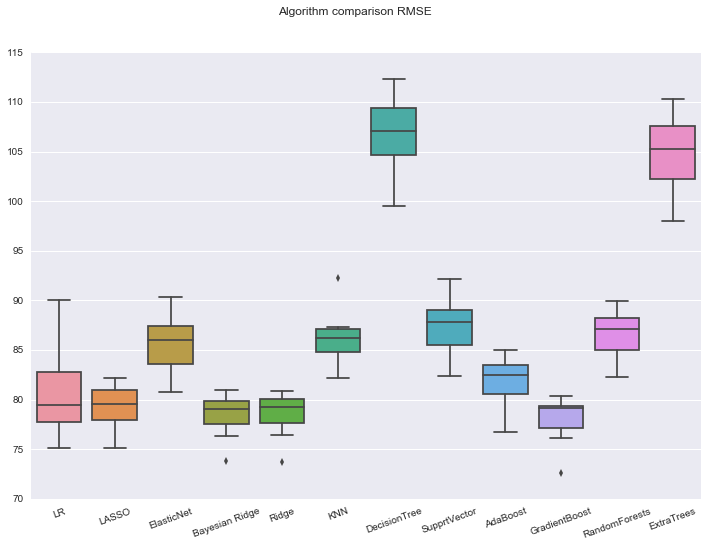

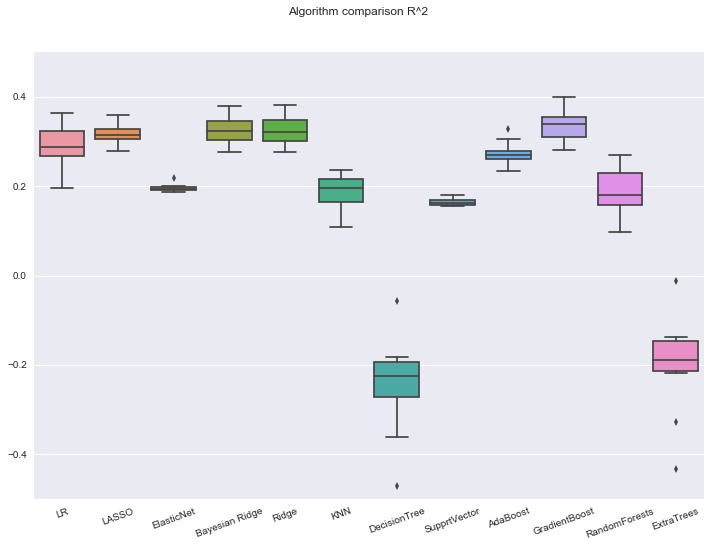

In [15]:
spot_check_models(X_train, y_train)

### Learning curves

In [29]:
X_train.shape

(4186L, 47L)

### Helper functions

In [16]:
def print_score(y_train, y_pred_train, y_test, y_pred_test):
    '''
    Print the RMSE and R^2 scores for train and test predictions
    '''
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    results_list = ['Train', 'Test']
    mae_both =[mae_train, mae_test]
    r2_both = [r2_train, r2_test]
    
    print '\tRMSE\t\tR2'
    for s, mae, r2 in zip(results_list, mae_both, r2_both):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}'.format(s, mae, 2)

In [17]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve2(estimator, title, X, y, ylim=None, cv=None):
    
    plt.figure(figsize=(5,2))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    #train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)
    train_sizes = np.linspace(.1, 1.0, 10)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            train_sizes=train_sizes, scoring='r2')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    #for size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
    #    print "Train size: %6d, Train Score: %.3f Test Score: %.3f" % (size, train_score, test_score)
    return plt

In [18]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve3( X, y):
   

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    #train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)
    train_sizes = np.linspace(.1, 1.0, 10)
    
    models = []
    models.append(LinearRegression())
    models.append(Lasso())  
    models.append(ElasticNet())
    models.append(BayesianRidge())
    models.append(Ridge())
    models.append(KNeighborsRegressor())
    models.append(DecisionTreeRegressor())
    models.append(SVR())
    models.append(AdaBoostRegressor() )
    models.append(GradientBoostingRegressor() )
    models.append(RandomForestRegressor() )
    models.append(ExtraTreesRegressor())
    
    fig = plt.figure(figsize=(10,20))
    #k = 0
    for k, model in enumerate(models):

        sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv,
                                                                train_sizes=train_sizes, scoring='r2')

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        
        # Subplot the learning curve 
        ax = fig.add_subplot(6, 2, k+1)
  
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')
        
        #k += 1
        
        # Labels
        ax.set_title(model.__class__.__name__)
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
        
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()

    #for size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
    #    print "Train size: %6d, Train Score: %.3f Test Score: %.3f" % (size, train_score, test_score)


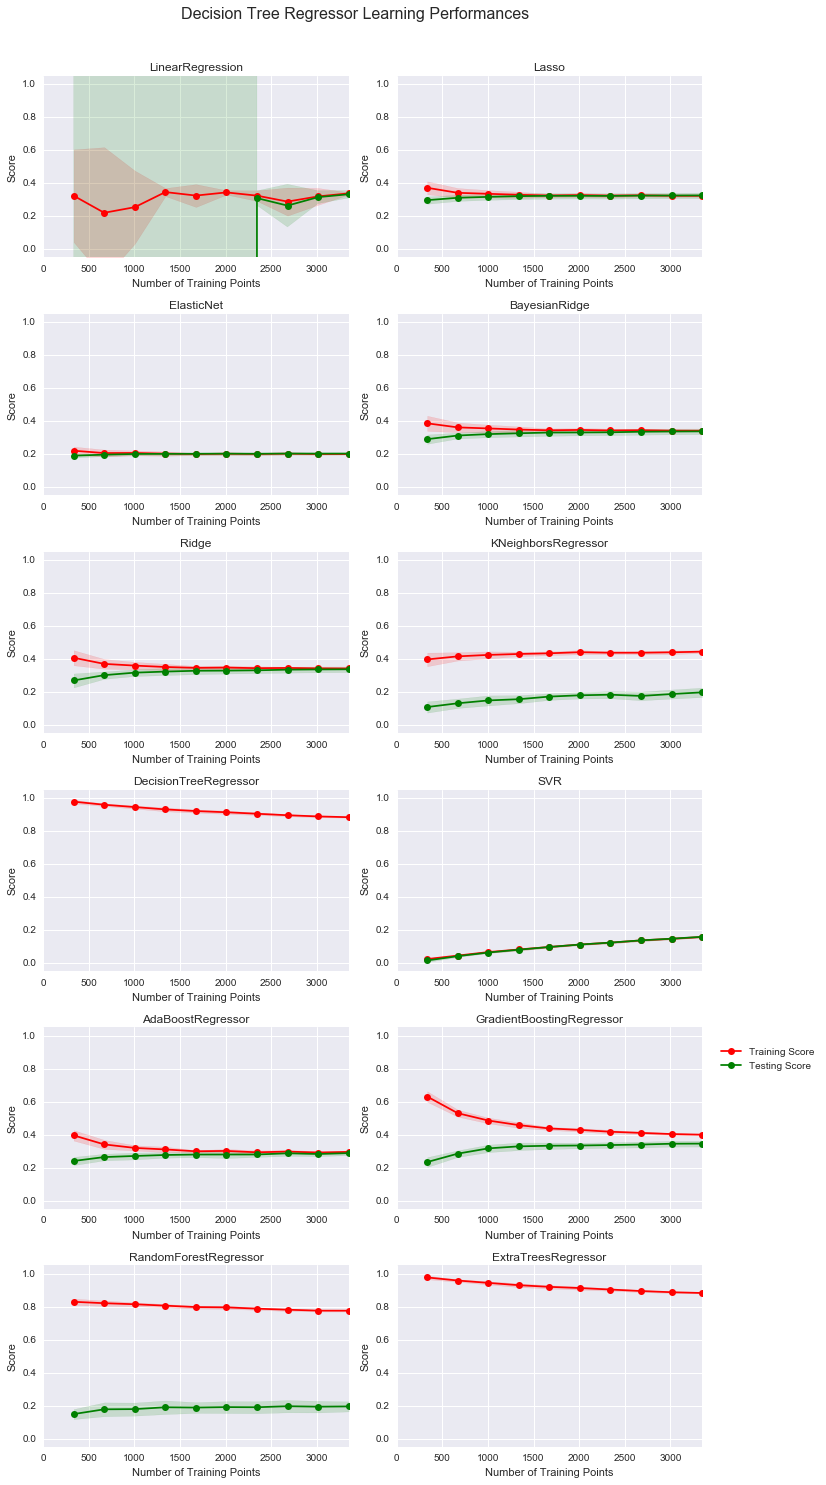

In [19]:
plot_learning_curve3(X_train, y_train)

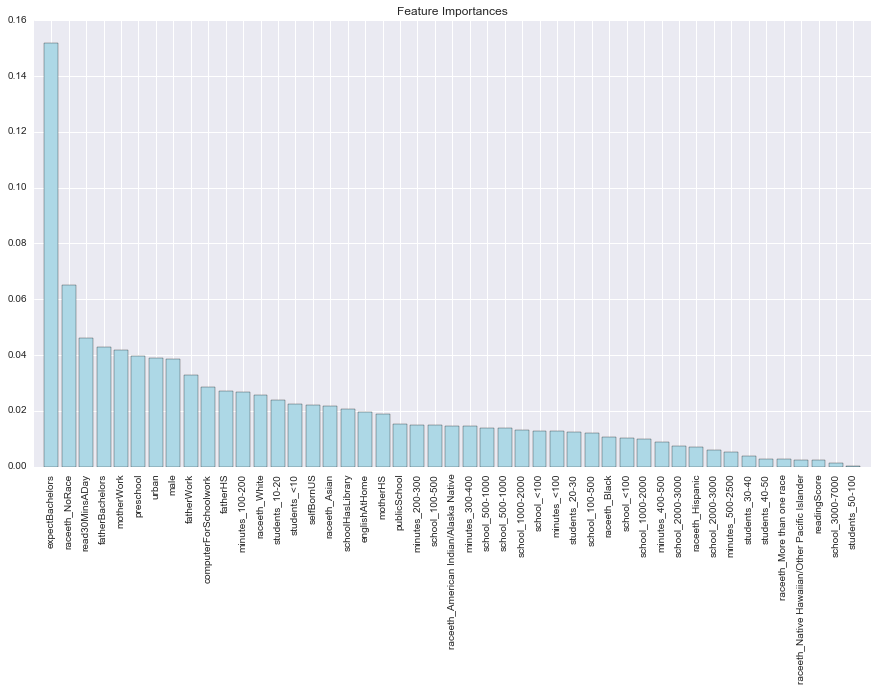

In [50]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = pisa.columns
labels_reordered = [feature_labels[i] for i in indices]
plt.figure(figsize=(15,8)) 
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices],color='lightblue', align='center')
plt.xticks(range(X_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X_train.shape[1]])
#plt.tight_layout()
plt.show()

In [45]:
featSel = indices[:8]

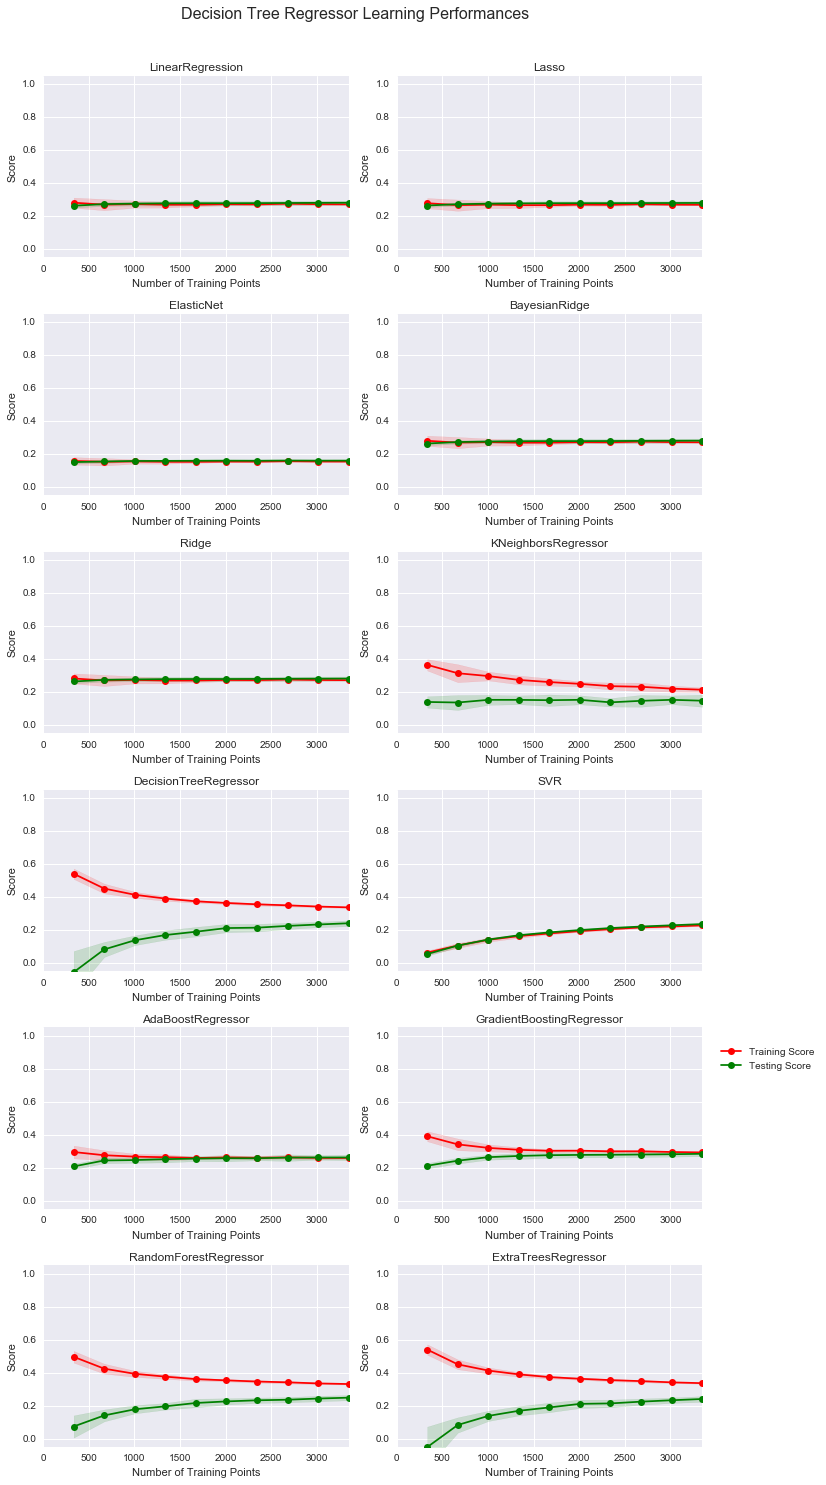

In [46]:
plot_learning_curve3(X_train[:,featSel], y_train)

In [32]:
def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))

In [ ]:
def generate_learningcurves(sparse=False,**kwargs):
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
    alg           = kwargs["alg"]
    alg_name      = alg.__class__.__name__
    
    if (sparse):
        train_sizes = np.linspace(.01, 1.0, 6)
    else:
        train_sizes = np.linspace(.01, 1.0, 20)
    
    # Plot learning curve
    X, y = gX_train, gy_train
    title = 'Learning Curves for Gap (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)
    estimator = alg
    plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    plt.show()

In [23]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    alg_name = estimator.__class__.__name__
    # Plot Learning Curve
    plt.figure(figsize=(15,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    

    start = timeit.default_timer()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Learning Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s) 
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    
    # Print Scores
    for train_size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
        print ('Train Size: {0:7d} Train Score: {1:.3f} Test Score: {2:.3f}' .format(int(train_size), float(train_score), float(test_score)))
    
    return plt

In [ ]:
np.rint(np.linspace(1, X_train.shape[0]*0.8 - 1, 9)).astype(int)

In [ ]:
plot_learning_curve2(LinearRegression(), 'Linear Regression model', X_train, y_train)

In [ ]:
def plot_validation_curve(estimator, X, y, param_name, param_range, 
                          scoring, plot_title, x_label, y_label, n_jobs=-1):
    
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=n_jobs)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:7d}    Train Score: {2:.3f} Test Score: {3:.3f}' .format(param_name, int(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

## Refinement

In [ ]:
def select_hyperparams(**kwargs):
        
    gX_train      = kwargs['gX_train']
    gy_train      = kwargs['gy_train']
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]

    
    alg           = kwargs['alg']
    alg_name      = kwargs['alg_name']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    start = timeit.default_timer()
    # Use nested cross validation - 5x2 cross validation
    g_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring=scoring_func,
                  cv=2,
                  n_jobs=-1)
   
    scores = cross_val_score(estimator=g_gs,
                         X=gX_train,
                         y=gy_train,
                         scoring=scoring_func,
                         cv=5)

    g_gs = g_gs.fit(X=gX_train, y=gy_train)
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'GridSearchCV Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    print 'All CV Scores:', scores
    print('Mean CV Score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print 'Best Estimator:\n', g_gs.best_estimator_

   
    # Generate Learning Curves
    generate_learningcurves(sparse=True, gX_train=gX_train, gy_train=gy_train,
                            alg=g_gs.best_estimator_, alg_name=alg_name)
    
    # Print All Scores   
    gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
# Random Forests only supports MSE score for deciding splits
generate_learningcurves(gX_train=X_train, gy_train=y_train, alg=DecisionTreeRegressor())

In [36]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_

In [37]:
indices = np.argsort(importances)[::-1]
feature_labels = pisa.columns
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))


 1) expectBachelors                0.146464
 2) raceeth_NoRace                 0.073096
 3) read30MinsADay                 0.051281
 4) preschool                      0.041698
 5) fatherBachelors                0.040601
 6) male                           0.040151
 7) motherWork                     0.039492
 8) urban                          0.034804
 9) fatherWork                     0.033541
10) students_10-20                 0.028016
11) computerForSchoolwork          0.027317
12) raceeth_White                  0.027311
13) minutes_100-200                0.026722
14) fatherHS                       0.024465
15) students_<10                   0.023336
16) englishAtHome                  0.021467
17) selfBornUS                     0.021245
18) motherHS                       0.020962
19) schoolHasLibrary               0.019561
20) raceeth_Asian                  0.017389
21) raceeth_American Indian/Alaska Native 0.016164
22) minutes_<100                   0.015547
23) publicSchool         

In [ ]:
labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Gap Feature Importances')
plt.bar(range(X_train.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(X_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X_train.shape[1]])
#plt.tight_layout()
plt.show()

In [38]:
indices

array([ 2, 22, 11,  1,  6,  0,  4, 14,  7, 31, 10, 23, 25,  5, 30,  9,  8,
        3, 12, 17, 16, 24, 13, 44, 26, 43, 38, 27, 45, 37, 32, 36, 39, 42,
       18, 28, 19, 46, 40, 29, 20, 33, 34, 15, 21, 35, 41], dtype=int64)

In [ ]:
generate_learningcurves(gX_train=X_train[:,[2, 22, 11,  6,  4,  0,  1, 14,  7, 10, 29,  5, 30, 28, 24,  3,  9]], gy_train=y_train, alg=LinearRegression())

In [33]:
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()

In [34]:
ModelComplexity(X_train, y_train)

NameError: global name 'validation_curve' is not defined

In [ ]:
from sklearn.feature_selection import RFECV
selector = RFECV(estimator=LinearRegression(), cv=10, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)
print("Optimal number of features: %d" % selector.n_features_)

In [ ]:
X_train.shape

In [ ]:
pisa.columns[selector.support_]

In [ ]:
pisa.columns

In [ ]:
selector.support_

In [ ]:
X_train[:, selector.support_].shape

In [ ]:
ModelComplexity(X_train[:, selector.support_], y_train)

In [ ]:
generate_learningcurves(gX_train=X_train[:,[2, 22, 11,  6,  4,  0,  1, 14,  7, 10, 29,  5, 30, 28, 24,  3,  9]], gy_train=y_train, alg=GradientBoostingRegressor())

# IV. Results

## Model Evaluation and Validation

## Justification

# V. Conclusion

## Free-Form Visualization

## Reflection

## Improvement